In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from tensorflow import keras

# Data selection

Skip this if you already have the trump.csv and play.csv files.

We want to learn from the best players and not upload 1.34 GB of data to git, so we'll select our data here.

      id       mean        std     nr
1   6955  76.191936  41.780344   4241
2  54404  78.010880  41.985297   7445
3  74994  76.775460  41.428476   7669
4  56143  76.774029  41.546253    978
5    694  77.530707  42.514268  20989
Games played: 5308654
              mean          std            nr
count  4608.000000  4608.000000   4608.000000
mean     77.425642    42.107799   1152.051649
std       7.600044     5.341363   2482.719484
min       0.000000     0.000000      1.000000
25%      75.173385    40.801613     14.000000
50%      78.061368    42.248217     74.000000
75%      80.107041    43.500008   1081.750000
max     140.000000    92.630988  24413.000000
Games played (strong players): 834214


<AxesSubplot:>

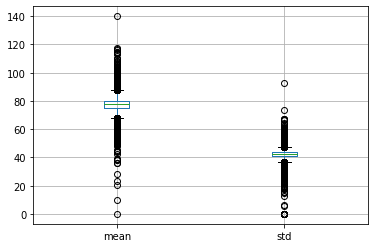

In [7]:
stat = pd.read_json(Path("training_data_deep") / "player_all_stat.json", orient="values")[1:]
print(stat.head())

print(f"Games played: {stat['nr'].sum()}")
print(stat[["mean", "std", "nr"]].describe())
# According to box plot, the 25% best players have a mean score of 80 or more.
# Taking only the best players is useless if there isn't enough data, so let's check.
print (f"Games played (strong players): {stat[stat['mean'] >= 80]['nr'].sum()}") # 834214 games played by strong players. Seems promising.

stat.boxplot(column=["mean", "std"])

In [8]:
strong_player_ids = stat[stat['mean'] >= 80].nr
print(strong_player_ids.head())
print(strong_player_ids.shape[0])

10     9382
20     6701
28     2611
34     5088
35    16552
Name: nr, dtype: int64
1192


In [9]:
import json

from jass.game.game_state_util import calculate_starting_hands_from_game
from jass.logs.game_log_entry import GameLogEntry

# Collect all game data, ignore games without strong players.
log_entries = []
for i in range(1, 20):
    with open(Path("training_data_deep") / f"jass_game_{i:04d}.txt") as file:
        for line in file.readlines():
            content = json.loads(line)
            if any(player in strong_player_ids for player in content["player_ids"]):
                entry = GameLogEntry.from_json(content)
                log_entries.append(entry)

print(len(log_entries)) # 121582 entries does not match the number of games played according to player_all_stat.json
# Maybe the strong players often play against each other?

121582


In [10]:
# Sanity check
print(log_entries[0].player_ids)
print(2444 in strong_player_ids)

log_entries[0].game

[41259, 2444, 58905, 68126]
True


{'dealer': 0, 'player': -1, 'trump': 1, 'forehand': 0, 'declared_trump': 1, 'hands': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'tricks': array([[17,  9, 12, 15],
       [11, 35,  5, 14],
       [30, 27,  8, 31],
       [10, 23, 34, 16],
       [ 6,  0, 26,  4],
       [ 1, 25,  7, 33],
       [ 2, 20,  3, 24],
       [18, 32, 19, 13],
       [21, 22, 29, 28]]), 'trick_winner': array([1, 2, 1, 1, 0, 0, 0, 1, 1]), 'trick_points': array([31, 17, 23,  4, 21,  4,  8, 25, 24]), 'trick_first_player': array([3, 1, 2, 1, 1, 0, 0, 0, 1]), 'curr

In [14]:
# Create TRUMP data
import csv

from jass.game.const import PUSH_ALT, color_of_card, DIAMONDS, HEARTS, SPADES, CLUBS, A_offset, K_offset, Q_offset, J_offset, Ten_offset, Nine_offset, Eight_offset, Seven_offset, Six_offset
from jass.game.game_state_util import state_for_trump_from_complete_game

def get_trump_data_row(game):
    hand = list(game.hands[game.player])
    forehand = [game.forehand + 1]

    card_indices = np.flatnonzero(hand)
    nr_cards = []
    for color in [DIAMONDS, HEARTS, SPADES, CLUBS]:
        nr_cards = nr_cards + [sum(color_of_card[card] == color for card in card_indices)]
    for card_value in [A_offset, K_offset, Q_offset, J_offset, Ten_offset, Nine_offset, Eight_offset, Seven_offset, Six_offset]:
        nr_cards = nr_cards + [sum(card % 9 == card_value for card in card_indices)]

    trump = [game.trump]

    return hand + forehand + nr_cards + trump

with open(Path("training_data_deep") / "trump.csv", "w", newline="") as file:
    writer = csv.writer(file)
    for log_entry in log_entries:
        game = state_for_trump_from_complete_game(log_entry.game, for_forhand=True)
        if log_entry.player_ids[game.player] in strong_player_ids:
            game.trump = log_entry.game.trump if log_entry.game.forehand == 1 else PUSH_ALT
            writer.writerow(get_trump_data_row(game))

        if log_entry.game.forehand != 1:
            game = state_for_trump_from_complete_game(log_entry.game, for_forhand=False)
            if log_entry.player_ids[game.player] in strong_player_ids:
                game.trump = log_entry.game.trump
                writer.writerow(get_trump_data_row(game))


In [10]:
# Create PLAY data
import csv

from jass.game.const import color_of_card
from jass.game.game_state_util import observation_from_state, state_from_complete_game
from jass.game.rule_schieber import RuleSchieber

# Dumping the data into a csv, so we don't have to upload > 1 GB of data to git.
rule = RuleSchieber()

def get_play_data_row(obs, valid_cards, card_played):
    hand = list(obs.hand)
    playable_hand = list(valid_cards)
    used_cards = list(get_used_cards(obs))
    current_trick = list(get_current_trick(obs))
    color_of_first_card = list(get_color_of_first_card(obs))
    trump = list(get_trump(obs))
    played_now = [obs.nr_cards_in_trick]
    played_total = [obs.nr_played_cards]

    return hand + playable_hand + used_cards + current_trick + color_of_first_card + trump + played_now + played_total + [card_played]

def get_used_cards(obs):
    used_cards = obs.tricks.flat
    result = np.zeros(shape=36, dtype=np.int32)
    result[used_cards[used_cards >= 0]] = 1
    return result

def get_current_trick(obs):
    result = np.zeros(shape=36, dtype= np.int32)
    result[obs.current_trick[obs.current_trick >= 0]] = 1
    return result

def get_color_of_first_card(obs):
    result = np.zeros(shape=4, dtype= np.int32)
    first_card = obs.current_trick[0]
    if first_card >= 0:
        result[color_of_card[first_card]] = 1
    return result

def get_trump(obs):
    result = np.zeros(shape=6, dtype= np.int32)
    result[obs.trump] = 1
    return result

with open(Path("training_data_deep") / "play.csv", "w", newline="") as file:
    writer = csv.writer(file)
    for log_entry in log_entries:
        game = state_from_complete_game(log_entry.game, 0)
        for i in range(36):
            next_game = None if i == 35 else state_from_complete_game(log_entry.game, i + 1)

            if log_entry.player_ids[game.player] in strong_player_ids:
                obs = observation_from_state(game)
                valid_cards = rule.get_valid_cards_from_obs(obs)
                hand = np.flatnonzero(valid_cards)
                
                card_played = hand[0] if len(hand) == 1 else next_game.tricks[game.nr_tricks][game.nr_cards_in_trick]

                writer.writerow(get_play_data_row(obs, valid_cards, card_played))

            game = next_game

## Trump

In [50]:
from jass.game.const import card_strings, trump_strings_short

data = pd.read_csv(Path("training_data_deep") / "trump.csv", header=None).astype(float)

cards = list(card_strings)
forehand = ["FH"]
nr_color = [f"nr_{color}" for color in trump_strings_short[:4]]
nr_value = [f"nr_{value}" for value in ["A", "K", "Q", "J", "10", "9", "8", "7", "6"]]
trump = ["trump"]

feature_columns = cards + forehand + nr_color + nr_value
data.columns = feature_columns + trump

# Normalize data
data[nr_color] = data[nr_color] / 9.0
data[nr_value] = data[nr_value] / 4.0
# Column "trump" will be converted to categorical and does not need to be normalized.

print(data.head())

    DA   DK   DQ   DJ  D10   D9   D8   D7   D6   HA  ...  nr_A  nr_K  nr_Q  \
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.25  0.25  0.25   
1  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  ...  0.50  0.25  0.25   
2  0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  ...  0.25  0.50  0.25   
3  0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  1.0  ...  0.25  0.50  0.00   
4  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.25  0.25  0.25   

   nr_J  nr_10  nr_9  nr_8  nr_7  nr_6  trump  
0  0.50   0.25  0.00  0.75  0.00  0.00    1.0  
1  0.00   0.00  0.50  0.25  0.25  0.25    0.0  
2  0.25   0.50  0.25  0.25  0.00  0.00    1.0  
3  0.50   0.25  0.25  0.25  0.25  0.00    6.0  
4  0.50   0.50  0.00  0.25  0.25  0.00    1.0  

[5 rows x 51 columns]


In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = (dataframe.values for dataframe in train_test_split(data[feature_columns], data.trump, test_size=0.2, stratify=data.trump, random_state=42))

y_train, y_test = (keras.utils.to_categorical(y, num_classes=7) for y in (y_train, y_test))

print(X_train)
print(X_train.shape)
print(y_train)
print(y_train.shape)

[[0.   0.   0.   ... 0.25 0.25 0.  ]
 [0.   0.   0.   ... 0.25 0.25 0.75]
 [0.   1.   0.   ... 0.25 0.25 0.  ]
 ...
 [1.   0.   0.   ... 0.25 0.25 0.25]
 [0.   0.   1.   ... 0.25 0.   0.5 ]
 [0.   0.   1.   ... 0.5  0.5  0.  ]]
(40501, 50)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(40501, 7)


Epoch 1/100
304/304 [==============================] - 0s 1ms/step - loss: 1.5605 - accuracy: 0.4418 - val_loss: 1.3039 - val_accuracy: 0.5497
Epoch 2/100
304/304 [==============================] - 0s 783us/step - loss: 1.1455 - accuracy: 0.5837 - val_loss: 1.0538 - val_accuracy: 0.6184
Epoch 3/100
304/304 [==============================] - 0s 763us/step - loss: 0.9853 - accuracy: 0.6374 - val_loss: 0.9267 - val_accuracy: 0.6652
Epoch 4/100
304/304 [==============================] - 0s 766us/step - loss: 0.8460 - accuracy: 0.6843 - val_loss: 0.7962 - val_accuracy: 0.7043
Epoch 5/100
304/304 [==============================] - 0s 770us/step - loss: 0.7324 - accuracy: 0.7244 - val_loss: 0.7022 - val_accuracy: 0.7390
Epoch 6/100
304/304 [==============================] - 0s 763us/step - loss: 0.6702 - accuracy: 0.7472 - val_loss: 0.6683 - val_accuracy: 0.7485
Epoch 7/100
304/304 [==============================] - 0s 757us/step - loss: 0.6403 - accuracy: 0.7584 - val_loss: 0.6453 - val_accu

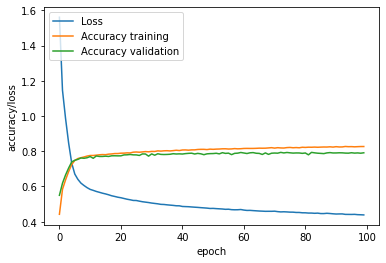

In [52]:
model = keras.Sequential()
model.add(keras.layers.Dense(50, activation="relu", input_shape=[X_train.shape[1]]))
for i in range(50, 6, -13):
    model.add(keras.layers.Dense(i, activation="relu"))
model.add(keras.layers.Dense(7, activation="softmax"))
model.compile(loss="categorical_crossentropy",
              optimizer="adamax",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_split=0.25, epochs=100, batch_size=100)

import matplotlib.pyplot as plt
plt.xlabel("epoch")
plt.ylabel("accuracy/loss")
plt.plot(history.history["loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Accuracy training", "Accuracy validation"], loc="upper left")

In [57]:
score = model.evaluate(X_test, y_test)
print(f"Loss: {score[0]}")
print(f"Accuracy: {score[1]}")
# 78% accuracy on unseen data.

317/317 [==============================] - 0s 388us/step - loss: 0.5428 - accuracy: 0.7837
Loss: 0.5427846312522888
Accuracy: 0.7837250828742981


In [58]:
model.save(Path("trained_model") / "trump_deep_neural_network.h5")

In [59]:
# Restore model to test if it still works.
model = keras.models.load_model(Path("trained_model") / "trump_deep_neural_network.h5")

In [60]:
score = model.evaluate(X_test, y_test)
print(f"Loss: {score[0]}")
print(f"Accuracy: {score[1]}") # Should have same accuracy as above.

317/317 [==============================] - 0s 397us/step - loss: 0.5428 - accuracy: 0.7837
Loss: 0.5427846312522888
Accuracy: 0.7837250828742981


In [61]:
# Check if model works well and how it responds

trump = [
    "DIAMONDS",
    "HEARTS",
    "SPADES",
    "CLUBS",
    "OBE_ABE",
    "UNE_UFE",
    "PUSH"
]

#           Diamonds   Rest        Forehand #D   #HSC       #each value
pred_data = [1.] * 9 + [0.] * 27 + [0.] + [1.] + [0.] * 3 + [1. / 4.] * 9
result = np.argmax(model.predict([pred_data]))
print(trump[result]) # Should choose DIAMONDS

#           Rest        Clubs      Forehand   #DHS   #C     #each value
pred_data = [0.] * 27 + [1.] * 9 + [1.] + [0.] * 3 + [1.] + [1. / 4.] * 9
result = np.argmax(model.predict([pred_data]))
print(trump[result]) # Should choose CLUBS

#           D 9-A      D 6-8      H 8-A      H 6&7      S 8-A      S 6&7      C 8-A      C 6&7      Forehand      #D   #HSC
pred_data = [0.] * 6 + [1.] * 3 + [0.] * 7 + [1.] * 2 + [0.] * 7 + [1.] * 2 + [0.] * 7 + [1.] * 2 + [1.] + [3. / 9.] + [2. / 9.] * 3 + [0.] * 6 + [1. / 4.] + [2. / 4.] * 2
result = np.argmax(model.predict([pred_data]))
print(trump[result]) # Should choose UNE_UFE

OBE_ABE
OBE_ABE
UNE_UFE


## Play card

In [22]:
from jass.game.const import card_strings, trump_strings_short

data = pd.read_csv(Path("training_data_deep") / "play.csv", header=None).astype(float)

cards = list(card_strings)
playable_cards = [f"valid_{c}" for c in card_strings]
used_cards = [f"used_{c}" for c in card_strings]
current_trick = [f"trick_{c}" for c in card_strings]
color_of_first_card = [f"first_{t}" for t in trump_strings_short[:4]]
trump = [f"trump_{t}" for t in trump_strings_short[:6]]
nr_played_now = ["# played now"]
nr_played_total = ["# played total"]
played = ["played"]

feature_columns = cards + playable_cards + used_cards + current_trick + color_of_first_card + trump + nr_played_now + nr_played_total
data.columns = feature_columns + played

# Normalize data
data[nr_played_now] = data[nr_played_now] / 3.0
data[nr_played_total] = data[nr_played_total] / 35.0
# Column "played" will be converted to categorical and does not need to be normalized.

print(data.head())

    DA   DK   DQ   DJ  D10   D9   D8   D7   D6   HA  ...  first_C  trump_D  \
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...      0.0      0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...      0.0      0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...      1.0      0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...      0.0      0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...      0.0      0.0   

   trump_H  trump_S  trump_C  trump_O  trump_U  # played now  # played total  \
0      1.0      0.0      0.0      0.0      0.0      0.666667        0.057143   
1      1.0      0.0      0.0      0.0      0.0      0.000000        0.114286   
2      1.0      0.0      0.0      0.0      0.0      0.333333        0.257143   
3      1.0      0.0      0.0      0.0      0.0      0.000000        0.342857   
4      1.0      0.0      0.0      0.0      0.0      0.000000        0.457143   

   played  
0    12.0  
1    11.0  
2    27.0  
3 

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = (dataframe.values for dataframe in train_test_split(data[feature_columns], data[played], test_size=0.2, stratify=data[played], random_state=42))

y_train, y_test = (keras.utils.to_categorical(y, num_classes=36) for y in (y_train, y_test))

print(X_train)
print(X_train.shape)
print(y_train)
print(y_train.shape)

[[1.         1.         0.         ... 0.         0.66666667 0.28571429]
 [0.         0.         1.         ... 0.         0.66666667 0.4       ]
 [0.         0.         0.         ... 0.         0.66666667 0.97142857]
 ...
 [0.         0.         0.         ... 1.         0.66666667 0.05714286]
 [0.         0.         0.         ... 0.         1.         0.54285714]
 [0.         0.         0.         ... 0.         0.66666667 0.74285714]]
(900856, 156)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(900856, 36)


Epoch 1/100
6757/6757 [==============================] - 8s 1ms/step - loss: 2.2379 - accuracy: 0.3657 - val_loss: 1.3694 - val_accuracy: 0.5274
Epoch 2/100
6757/6757 [==============================] - 8s 1ms/step - loss: 1.2536 - accuracy: 0.5436 - val_loss: 1.1942 - val_accuracy: 0.5522
Epoch 3/100
6757/6757 [==============================] - 8s 1ms/step - loss: 1.1370 - accuracy: 0.5625 - val_loss: 1.1117 - val_accuracy: 0.5682
Epoch 4/100
6757/6757 [==============================] - 8s 1ms/step - loss: 1.0747 - accuracy: 0.5759 - val_loss: 1.0641 - val_accuracy: 0.5776
Epoch 5/100
6757/6757 [==============================] - 8s 1ms/step - loss: 1.0300 - accuracy: 0.5878 - val_loss: 1.0294 - val_accuracy: 0.5874
Epoch 6/100
6757/6757 [==============================] - 8s 1ms/step - loss: 0.9953 - accuracy: 0.5995 - val_loss: 0.9934 - val_accuracy: 0.6007
Epoch 7/100
6757/6757 [==============================] - 8s 1ms/step - loss: 0.9642 - accuracy: 0.6111 - val_loss: 0.9846 - val_ac

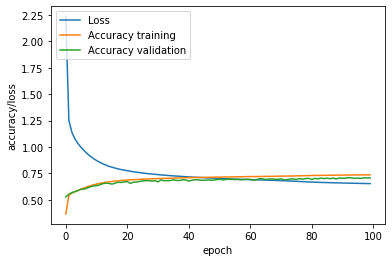

In [30]:
model = keras.Sequential()
model.add(keras.layers.Dense(156, activation="relu", input_shape=[X_train.shape[1]]))
for i in range(79, 36, -13):
    model.add(keras.layers.Dense(i, activation="relu"))
model.add(keras.layers.Dense(36, activation="softmax"))
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_split=0.25, epochs=100, batch_size=100)

import matplotlib.pyplot as plt
plt.xlabel("epoch")
plt.ylabel("accuracy/loss")
plt.plot(history.history["loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Accuracy training", "Accuracy validation"], loc="upper left")

In [31]:
score = model.evaluate(X_test, y_test)
print(f"Loss: {score[0]}")
print(f"Accuracy: {score[1]}")
# 70% accuracy on unseen data.

7038/7038 [==============================] - 3s 490us/step - loss: 0.7264 - accuracy: 0.7084
Loss: 0.7263946533203125
Accuracy: 0.7083587050437927


In [32]:
model.save(Path("trained_model") / "play_deep_neural_network.h5")